# SYS 611: SimPy Factory System

Paul T. Grogan <pgrogan@stevens.edu>

This example creates a factory system simulation in SimPy.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy`, `matplotlib.pyplot` and `simpy` libraries. SimPy is not a standard library included in most Python distributions. The `!pip install simpy` command below attempts to install it using the pip package management system.

In [1]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy package and refer to it as `np`
import numpy as np

# import the matplotlib pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

!pip install simpy

# import the simpy package
import simpy

## Simulation Model

Total cost: 437491.88


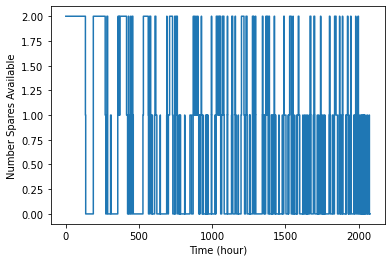

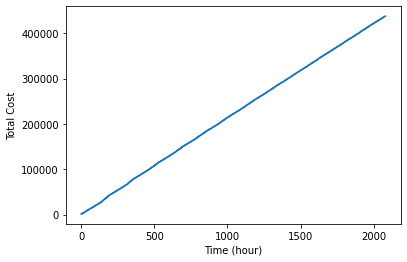

In [2]:
def factory_run(env, repairers, spares):
    """ Process to run this simulation. 
        
    Args:
        env (simpy.Environment): the simulation environment
        repairers (simpy.Resource): the repairers resource
        spares (simpy.Container): the spares container
    """
    # define global variables for inter-process communication
    # note: this is a bad practice; however, is OK in this small script
    global cost
    cost = 0
    
    # launch the 50 machine processes
    for i in range(50):
        env.process(operate_machine(env, repairers, spares))
    # update the daily costs each day
    while True:
        cost += 3.75*8*repairers.capacity + 30*spares.capacity
        yield env.timeout(8.0)

def operate_machine(env, repairers, spares):
    """ Process to operate a machine.
    
    Args:
        env (simpy.Environment): the simulation environment
        repairers (simpy.Resource): the repairers resource
        spares (simpy.Container): the spares container
    """
    # define global variables for inter-process communication
    # note: this is a bad practice; however, is OK in this small script
    global cost
    
    while True:
        # wait until the machine breaks
        yield env.timeout(np.random.uniform(132,182))
        time_broken = env.now
        # launch the repair process
        env.process(repair_machine(env, repairers, spares))
        # wait for a spare to become available
        yield spares.get(1)
        time_replaced = env.now
        # update the cost for being out of service
        cost += 20*(time_replaced-time_broken)        

def repair_machine(env, repairers, spares):
    """ Process to repair a machine. 

    Args:
        env (simpy.Environment): the simulation environment
        repairers (simpy.Resource): the repairers resource
        spares (simpy.Container): the spares container    
    """
    with repairers.request() as request:
        # wait for a repairer to become available
        yield request
        # perform the repair
        yield env.timeout(np.random.uniform(4,10))
        # put the machine back in the spares pool
        yield spares.put(1)    

def observe(env, spares):
    """ Process to observe the factory during a simulation.
    
    Args:
        env (simpy.Environment): the simulation environment
        factory (Factory): the factory
    """
    while True:
        obs_time.append(env.now)
        obs_cost.append(cost)
        obs_spares.append(spares.level)
        yield env.timeout(1.0)
        
# create the simulation environment
env = simpy.Environment()

# create arrays to record data
obs_time = []
obs_cost = []
obs_spares = []

# create the resources
repairers = simpy.Resource(env, capacity=50)
spares = simpy.Container(env, init=2, capacity=2)

# add the factory run process
env.process(factory_run(env, repairers, spares))
# add the observation process
env.process(observe(env, spares))
# run simulation
env.run(until=8*5*52)

print('Total cost: {:.2f}'.format(cost))

# plot the number of spares available
plt.figure()
plt.step(obs_time, obs_spares, where='post')
plt.xlabel('Time (hour)')
plt.ylabel('Number Spares Available')
plt.show()

# plot the total cost accumulation
plt.figure()
plt.step(obs_time, obs_cost, where='post')
plt.xlabel('Time (hour)')
plt.ylabel('Total Cost')
plt.show()

## Monte Carlo Simulation

To run a Monte Carlo simulation, all of the processes can be reused from the single simulation case.

In [3]:
NUM_RUNS = 10
# number of spares to purchase (S)
NUM_SPARES = 2
# number of repairers to hire (R)
NUM_REPAIRERS = 50

# array to store outputs
COST = []

for i in range(NUM_RUNS):
    # set the random number seed
    np.random.seed(i)
    
    # create the simpy environment
    env = simpy.Environment()
    
    # create arrays to record data
    obs_time = []
    obs_cost = []
    obs_spares = []
    
    # create the resources
    repairers = simpy.Resource(env, capacity=NUM_REPAIRERS) 
    spares = simpy.Container(env, init=NUM_SPARES, capacity=NUM_SPARES)
    
    # add the factory run process
    env.process(factory_run(env, repairers, spares))
    
    # add the observation process
    env.process(observe(env, spares))
    
    # run simulation
    env.run(until=5*8*52)
    
    # record the final cost
    COST.append(cost)


# print final results to console
print('Factory costs for N={:} runs with R={:} repairers and S={:} spares:'.format(
        NUM_RUNS, NUM_REPAIRERS, NUM_SPARES))
print('\n'.join('{:.2f}'.format(i) for i in COST))

# write results to CSV file
import csv

with open('factory.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerow(['Run', 'Final Cost'])
    for i, sample in enumerate(COST):
        writer.writerow([i+1, sample])

Factory costs for N=10 runs with R=50 repairers and S=2 spares:
439607.09
438908.93
440380.53
442121.18
442607.92
441996.90
439545.14
439061.08
439516.07
442552.17
